Import packages needed

In [2]:
import suite2p
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob
from natsort import natsorted
from multiprocessing import Pool
from joblib import Parallel, delayed
from pathlib import Path
import gc
gc.collect()
import importlib
import sys
import seaborn as sns
from pathlib import Path
# Add the directory containing your script to the Python path
sys.path.append(r'C:\Users\User\Project-SLMonlineControl\CodeAndPackages\PYsubfun')
#sys.path.append(r'C:\Users\zhangl33\Projects\Project-SLMonlineControl\CodeAndPackages\PYsubfun')

# Now you can import your script as a module
import FastBin_Suite2p as FBS
import CalBin2p as CB
import SLM_Offline as slmO
import Suite2p_QualityControl as QC 

In [3]:
#importlib.reload(FBS)
# Pre-set parameters, and load the only bin files in the pre-set path folde
ConfigFolder=r'C:\Users\User\Project-SLMonlineControl\config'
#ConfigFolder=r'C:\Users\zhangl33\Projects\Project-SLMonlineControl\config'
ops0, confSet=FBS.configLoad(ConfigFolder,'SLMsetting.yml','ops3Planes.npy')
SaveFolder=FBS.suite2pInitiate(ops0,ConfigFolder)
binFile = glob.glob(ops0['save_path0'] + '/TSeries*-001.bin')    ##<<<<<<<<<<<<<<<<<<<<<<<<<< Noted that there supposed be only one Bin Data file
#Load Data
print(binFile)
rawBin, FramePerPlane, TotalFrameNeed=FBS.LoadBin(binFile,ops0)
rawBin.shape

Processed data would be saved inE:\LuSLMOnlineTest\L00430\12182025\suite2p
File found: C:\Users\User\Project-SLMonlineControl\config\SLMsetting.yml
Copying to: E:\LuSLMOnlineTest\L00430\12182025\CurrentSLMsetting.yml
Current SLMsetting copied successfully!
['E:\\LuSLMOnlineTest\\L00430\\12182025\\TSeries-12182025-0938-001.bin']


(24600, 512, 512)

In [6]:
ops0['spatial_scale']=2
ops0['threshold_scaling']=1
ops0['denoise']=1
ops0['tau']=0.7
#suite2pdir=os.path.join(ops0["save_path0"],'suite2p')
#print(suite2pdir)
#suite2pdir=os.path.join(r'E:\LuSLMOnlineTest\L00121\09232025','suite2p')
combinedPath=os.path.join(SaveFolder,'combined')
print(combinedPath)

E:\LuSLMOnlineTest\L00430\12182025\suite2p\combined


Suite2p processing with no motion correction; Noted following defining a function to process a plane of data; Next session, parallel processing for each plane is excuted. Much time is saved. 
Alternatively, run this process with Step2-OnlineBinSuite2p.ipynb

In [7]:
# Define the number of parallel processes; 
# Noted that current binning movie in chuns of length 06; increase this parameter could decrease the number of frames within a chunks, using less memory
num_processes=1              ## <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
# Create a list of plane indices
plane_indices = range(0,ops0['nplanes'])
print(plane_indices)
ops1=ops0
Parallel(n_jobs=num_processes)(delayed(FBS.process_plane)(plane_idx, rawBin, SaveFolder, ops1) for plane_idx in plane_indices)

# Combine multiple plane data
#FBS.CombinePlanes(SaveFolder,ops0)
FBS.CombinePlanes(SaveFolder,ops0)

range(0, 3)
Processing plane 0
Saving folder already exists.
Binning movie in chunks of length 05
Binned movie of size [1640,512,512] created in 10.61 sec.
Binned movie denoised (for cell detection only) in 55.01 sec.
NOTE: FORCED spatial scale ~12 pixels, time epochs 1.37, threshold 13.67 
0 ROIs, score=183.37
Detected 102 ROIs, 27.44 sec
After removing overlaps, 101 ROIs remain
added enhanced mean image
Masks created, 0.40 sec.
Extracted fluorescence from 101 ROIs in 8200 frames, 9.88 sec.
Extracted fluorescence from 101 ROIs in 8200 frames, 9.94 sec.
['skew', 'compact', 'npix_norm']
Processing plane 1
Saving folder already exists.
Binning movie in chunks of length 05
Binned movie of size [1640,512,512] created in 9.02 sec.
Binned movie denoised (for cell detection only) in 50.12 sec.
NOTE: FORCED spatial scale ~12 pixels, time epochs 1.37, threshold 13.67 
0 ROIs, score=121.30
Detected 121 ROIs, 27.71 sec
After removing overlaps, 119 ROIs remain
added enhanced mean image
Masks creat

Run Suite2p gui from command line, load combined data above, do necessary mannual correction. Saved the data.

Once above mannual correction is done; update the result in each plane

In [ ]:
#importlib.reload(QC)

In [8]:
slmO.backup_iscell_npy(SaveFolder)
DEFAULT_PARAMS = {
    "nperseg": 512,
    "low_band": (0.2, 1.6),
    "high_band": (2.5, 3.3),
    "amp_method": "sum",
    "min_event_snr": 4,
    "amp_percentile": 0.5,
    "eps": 20,
    "recompute_spks": True,
}
params = {**DEFAULT_PARAMS, "low_band": (0.2, 1.6), "high_band": (2.5, 3.3)}
df_metrics, psdPerc, fre = QC.suite2pMetric(combinedPath, params)


6.9
0.7
60.0
20.0


In [11]:
# Step 1: Build the condition (boolean mask)
iscell_update = df_metrics['iscell'].to_numpy()
mask = (
    (df_metrics['footprint'] > 0.1) &
    (df_metrics['snr_oasis_evt'] > 1) &
    (df_metrics['mrs0'] > 2.6) &
    (df_metrics['compact'] < 1.1)&
    (df_metrics['iscell'] > 0)&
    (df_metrics['npix_soma'] > 50)&
    (df_metrics['sigma_psd'] < 250)&
    (df_metrics['LHR'] > 1.1)
)
mask = (
    (df_metrics['footprint'] > 0.1) &
    (df_metrics['snr_oasis_evt'] > 1) &
    (df_metrics['mrs0'] > 2.6) &
    (df_metrics['compact'] < 1.1)&
    (df_metrics['iscell'] > 0)&
    (df_metrics['npix_soma'] > 50)&
    (df_metrics['sigma_psd'] < 250)
)
# Step 2: Use np.where to get indices (like MATLAB find)
iscell_update = np.where(mask)[0]

print(len(iscell_update))  # e.g. [2 5 7]

77


In [12]:
[iscelltemp,stat_temp,plane_temp]=slmO.update_iscell(SaveFolder,iscell_update,3)

482 units total — 77 flagged as cells in combined data


Open Suite2p viewer, load the data, do mannual correction, save to mat!!

In [13]:
FBS.PostMannual(SaveFolder,ops0)

482 of units including 23 identified cells in combined planes


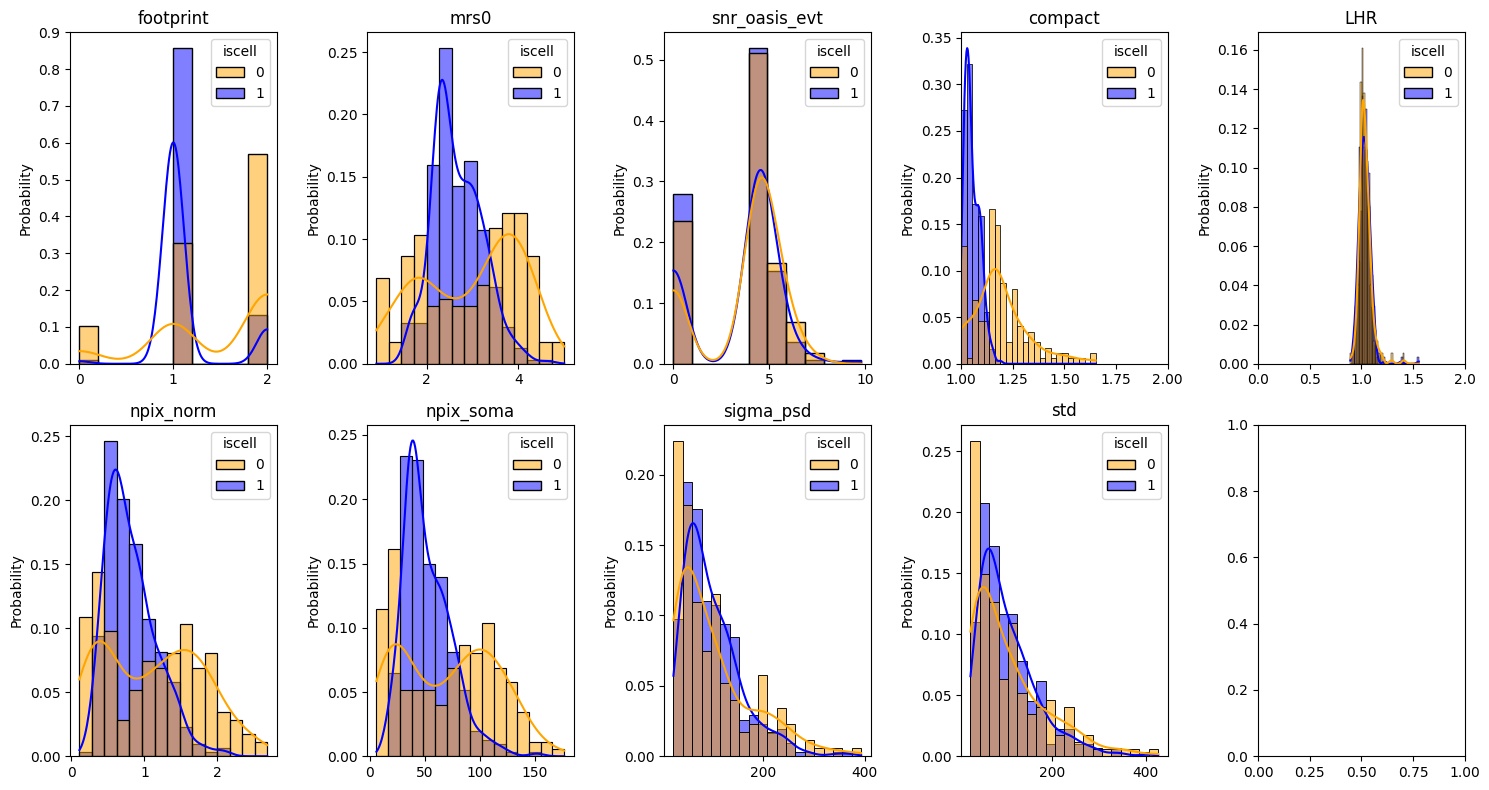

In [14]:
import seaborn as sns
metrics_subset = ['footprint','mrs0','snr_oasis_evt','compact','LHR','npix_norm','npix_soma','sigma_psd','std']

ncols = int(np.ceil(len(metrics_subset) / 2))   # columns needed
fig, axes = plt.subplots(2, ncols, figsize=(15, 8))  
axes = axes.flatten()

for idx, col in enumerate(metrics_subset):
    ax = axes[idx]
    sns.histplot(
        data=df_metrics,
        x=col,
        hue='iscell',
        hue_order=[0, 1],
        stat='probability',
        common_norm=False,
        kde=True,
        palette={0: "orange", 1: "blue"},
        alpha=0.5,
        ax=ax
    )
    ax.set_title(col)
    #ax.set_ylabel("Count")
    ax.set_xlabel("")
    if col == "LHR":
       ax.set_xlim(0, 2)   # adjust upper limit depending on your data spread
    if col == "compact":
       ax.set_xlim(1, 2)   # adjust upper limit depending on your data spread       
#    
plt.tight_layout()
plt.show()